In [ ]:
# !wget --directory-prefix=dataset/annotations-json http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.json

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from torchvision.models import ResNet50_Weights
import os
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
model=fasterrcnn_resnet50_fpn_v2(num_classes=183)
model.load_state_dict(torch.load('/content/drive/MyDrive/RCNN_30_Epoch/faster_rcnn_best_model.pth'))
model.weights_backbone=ResNet50_Weights.DEFAULT
model.to('cuda')

<ipython-input-40-c3d152872097>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/RCNN_30_Epoch/faster_rcnn_best_mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

<ipython-input-46-7084914aef2a>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):  # Enable autocast


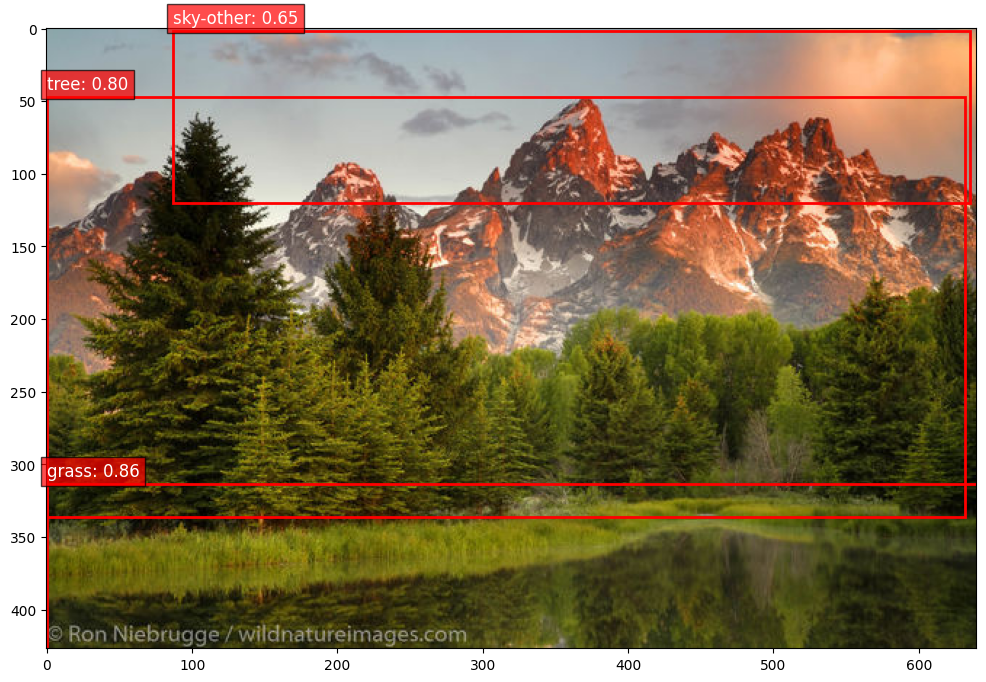

{'tree', 'grass', 'sky-other'}


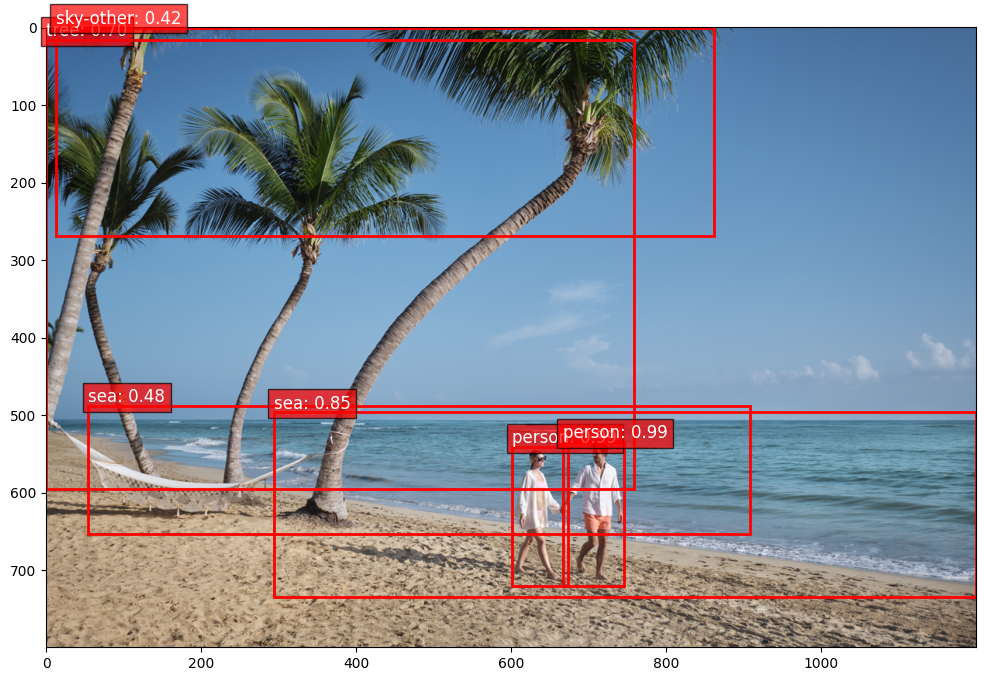

{'person', 'tree', 'sky-other', 'sea'}


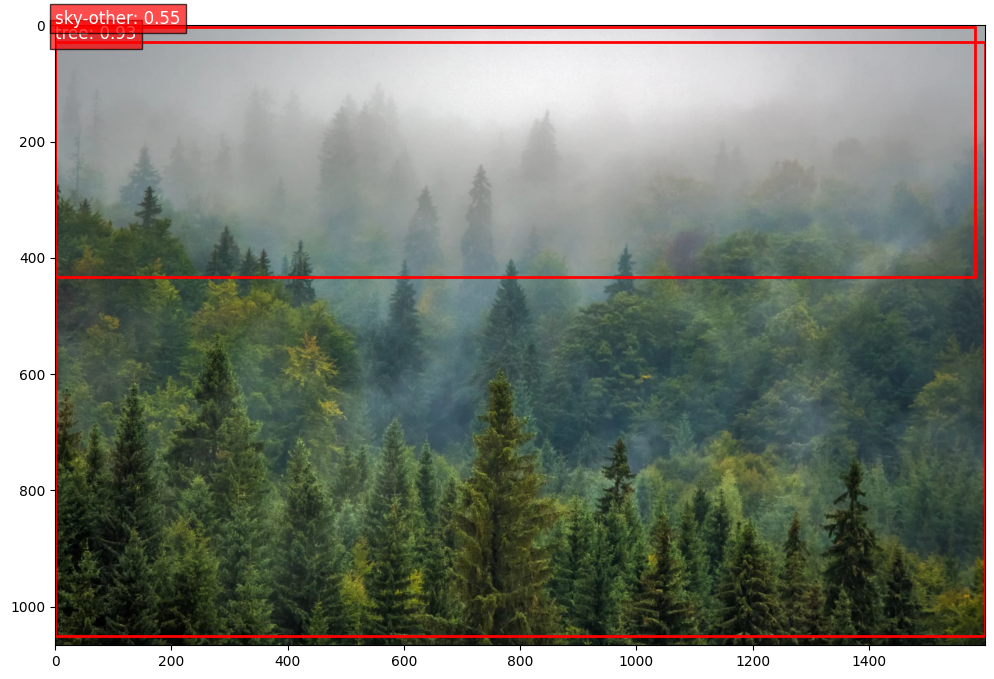

{'tree', 'sky-other'}


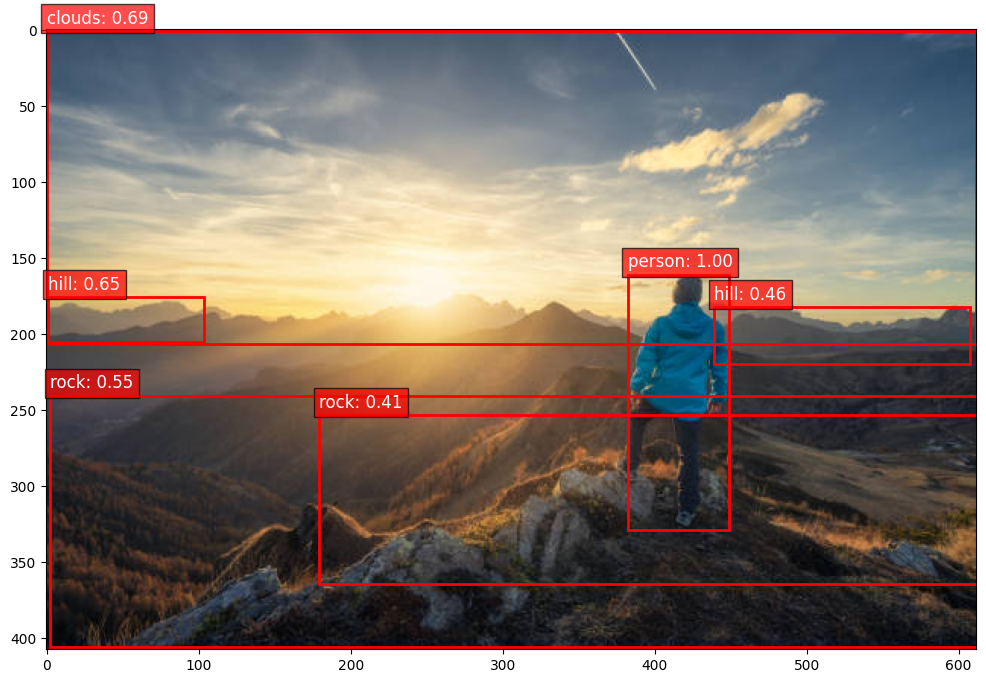

{'person', 'rock', 'hill', 'clouds'}


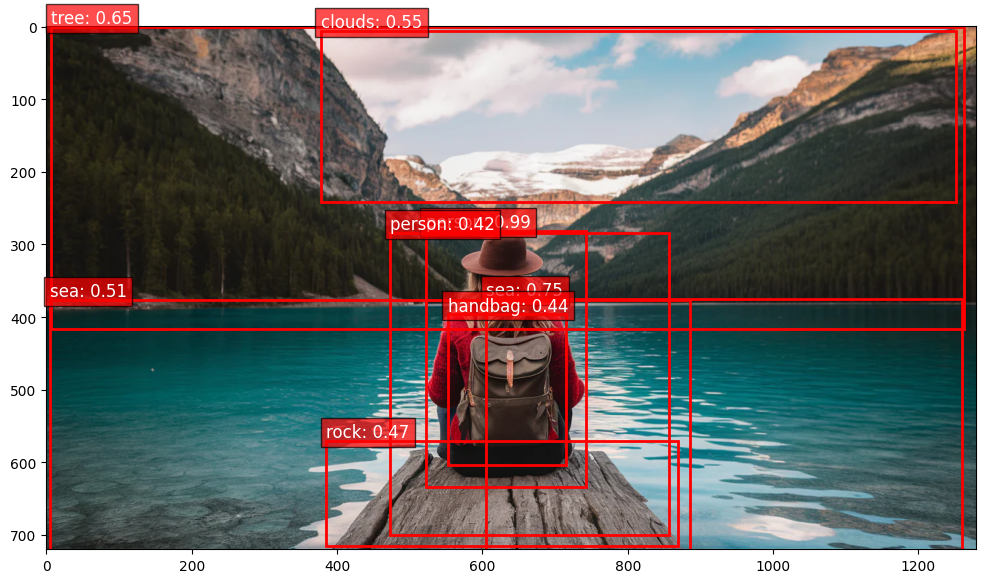

{'person', 'tree', 'rock', 'sea', 'handbag', 'clouds'}


In [ ]:
import json
import torch
from torchvision import models, transforms
from torchvision.ops import nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torch.cuda import amp
# Load the class mappings from a JSON file
def load_label_mapping(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract the categories and map the id to the name
    label_map = {category['id']: category['name'] for category in data['categories']}
    return label_map

# Function to visualize predictions with labels
def visualize_prediction(image, predictions, label_map, threshold=0.4):
    """
    Visualizes the predicted bounding boxes, labels, and scores on an image.
    Args:
        image (PIL Image or numpy.ndarray): Input image
        predictions (dict): Model's predictions (boxes, labels, scores)
        label_map (dict): Mapping of label IDs to human-readable class names
        threshold (float): Confidence threshold to display predictions
    """
    # Convert image to numpy array if it's a PIL Image
    labels_arr = []
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Get predictions
    boxes = predictions['boxes'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()

    for i in range(len(boxes)):
        if scores[i] > threshold:  # Filter predictions based on score
            rect = patches.Rectangle(
                (boxes[i][0], boxes[i][1]),
                boxes[i][2] - boxes[i][0],
                boxes[i][3] - boxes[i][1],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

            # Get the label name from label_map
            label_name = label_map.get(labels[i], 'Unknown')
            labels_arr.append(label_name)
            # Add label and score text
            ax.text(
                boxes[i][0], boxes[i][1] - 5,
                f'{label_name}: {scores[i]:.2f}',
                color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.7)
            )

    plt.show()
    return labels_arr

# Load a pretrained Faster R-CNN model (or your custom model)

model.eval()  # Set the model to evaluation mode
images=['/content/070620-014-The-Tetons.jpg','/content/beach-lovers-in-finest-punta-cana.jpg','/content/green-pine-trees-covered-with-fog_395237-31.jpg','/content/still-life-school-retro-ink-159618.jpg','/content/How_to_Stay_Healthy_While_Traveling_-_Tips_and_Insights_for_a_Safe_Journey.webp']
for img in images:
    # Load the image from file
  image_path = img  # Change this to the path of your image
  image = Image.open(image_path)

  # Define the necessary transformations for input image
  transform = transforms.Compose([
      transforms.ToTensor(),  # Convert image to tensor
  ])

  # Preprocess the image
  image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

  # Perform inference (predict)
  with torch.no_grad():
      image_tensor = image_tensor.to('cuda')
      with torch.cuda.amp.autocast(enabled=True):  # Enable autocast
        predictions = model(image_tensor)[0]  # Get predictions for the batch (assume batch size of 1)



  # Apply NMS
  iou_threshold = 0.5  # IoU threshold for NMS
  boxes = predictions['boxes']
  scores = predictions['scores']
  labels = predictions['labels']

  # Perform NMS
  keep_indices = nms(boxes, scores, iou_threshold)

  # Filter predictions based on NMS results
  filtered_predictions = {
      'boxes': boxes[keep_indices],
      'scores': scores[keep_indices],
      'labels': labels[keep_indices],
  }

  # Load label mapping from a JSON file
  label_map = load_label_mapping('/content/dataset/annotations-json/cocostuff-10k-v1.1.json')  # Update with your JSON path

  # Visualize the filtered predictions
  labels = set(visualize_prediction(image,filtered_predictions, label_map))
  print(labels)


